In [3]:
# !pip install leafmap

In [723]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
# import cv2
# from PIL import Image
%matplotlib inline
from geopandas import GeoSeries
from shapely.ops import cascaded_union
import leafmap
from shapely.geometry import MultiPoint
from shapely.geometry import Polygon

In [767]:
gdf = gpd.read_file("/work/mapsolution/data-1682398976674.csv")
gdf["geom"] = gpd.GeoSeries.from_wkb(gdf["geom"])
gdf = gdf[["筆id", "市区町村名", "大字名", "丁目名", "geom"]]
gdf["大字_丁目名"] = gdf["大字名"] + gdf["丁目名"]
gdf = gpd.GeoDataFrame(gdf, crs="EPSG:4326", geometry="geom")

In [768]:
gdf.head()

,筆id,市区町村名,大字名,丁目名,geom,大字_丁目名
0,H000002270,港区,新橋,６丁目,"MULTIPOLYGON (((-58.94100 79.57900, -63.70800 ...",新橋６丁目
1,H000000033,港区,愛宕,１丁目,"MULTIPOLYGON (((65.59800 182.31900, 65.64200 1...",愛宕１丁目
2,H000000003,港区,愛宕,１丁目,"MULTIPOLYGON (((85.65600 326.04200, 84.73100 3...",愛宕１丁目
3,H000000086,港区,愛宕,２丁目,"MULTIPOLYGON (((33.97900 103.74700, 33.96700 1...",愛宕２丁目
4,H000000020,港区,愛宕,１丁目,"MULTIPOLYGON (((52.48900 295.11800, 42.04900 2...",愛宕１丁目


In [769]:
gdf["大字_丁目名"].unique()

array(['新橋６丁目', '愛宕１丁目', '愛宕２丁目', '虎ノ門１丁目', '虎ノ門３丁目', '虎ノ門４丁目', '芝１丁目',
       '芝２丁目', '虎ノ門２丁目', '虎ノ門５丁目', '新橋５丁目', '新橋１丁目', '高輪２丁目', '高輪３丁目',
       '芝３丁目', '赤坂２丁目', '三田１丁目', '三田２丁目', '南青山３丁目', '港南２丁目', '赤坂５丁目',
       '高輪４丁目', '赤坂６丁目', '赤坂４丁目', '赤坂８丁目', '高輪１丁目', '東新橋１丁目', '東麻布１丁目',
       '南青山２丁目', '三田３丁目', '三田５丁目', '三田４丁目', '芝４丁目', '港南１丁目', '芝５丁目',
       '芝浦１丁目', '芝浦４丁目', '芝浦２丁目', '西麻布３丁目', '芝浦３丁目', '西麻布１丁目', '芝公園１丁目',
       '芝公園４丁目', '芝公園３丁目', '芝公園２丁目', '南青山４丁目', '新橋４丁目', '西麻布４丁目', '港南３丁目',
       '港南４丁目', '港南５丁目', '南青山６丁目', '新橋２丁目', '新橋３丁目', '西麻布２丁目', '赤坂１丁目',
       '六本木７丁目', '元赤坂１丁目', '元赤坂２丁目', '赤坂３丁目', '南青山５丁目', '南青山７丁目',
       '南麻布４丁目', '南麻布５丁目', '南麻布１丁目', '南麻布２丁目', '南麻布３丁目', '白金１丁目', '白金５丁目',
       '白金６丁目', '北青山１丁目', '赤坂７丁目', '赤坂９丁目', '東新橋２丁目', '東麻布２丁目', '南青山１丁目',
       '東麻布３丁目', '六本木３丁目', '白金２丁目', '白金３丁目', '白金４丁目', '白金台５丁目', '白金台３丁目',
       '北青山２丁目', '浜松町１丁目', '北青山３丁目', '麻布永坂町NULL', '元麻布１丁目', '元麻布２丁目',
       '六本木６丁目', '麻布十番１丁目', '麻布十番２丁目', '海岸１丁目', '麻布十番３丁目', '麻布十番４丁目

In [770]:
tdf = gdf[gdf["大字_丁目名"] == "西新橋１丁目"]

<Axes: >

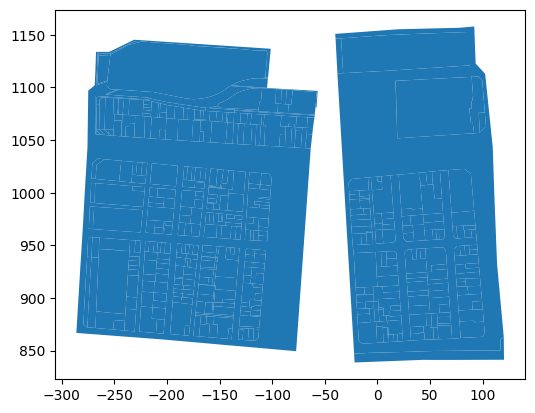

In [771]:
tdf["geom"].plot(aspect=1)

In [772]:
# 境界を取得
bound = gpd.GeoSeries(cascaded_union(tdf.geom))

<Axes: >

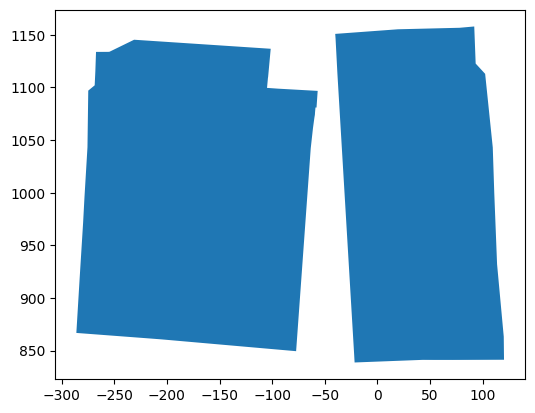

In [773]:
bound.plot()

In [774]:
bound

0    MULTIPOLYGON (((-255.712 1133.807, -254.484 11...
dtype: geometry

In [775]:
# MultipolygonをPolygonに変換
bdf = gpd.GeoDataFrame({
    "geometry": bound
}, crs=4326)

bdf = bdf.explode(index_parts=False).reset_index(False).reset_index(False)
bdf

,level_0,index,geometry
0,0,0,"POLYGON ((-255.71200 1133.80700, -254.48400 11..."
1,1,0,"POLYGON ((-40.09700 1150.87400, 19.57900 1155...."


In [776]:
# 抽出レコードに幾つのポリゴンが含まれているか
Polygon_Num = bdf.shape[0]
print(Polygon_Num)

2


In [777]:
# ポリゴンの外周を取得する
# TODO 点を増やすために線型補完したい
bdf.geometry = bdf.geometry.apply(lambda x: MultiPoint(list(x.exterior.coords)))

<Axes: >

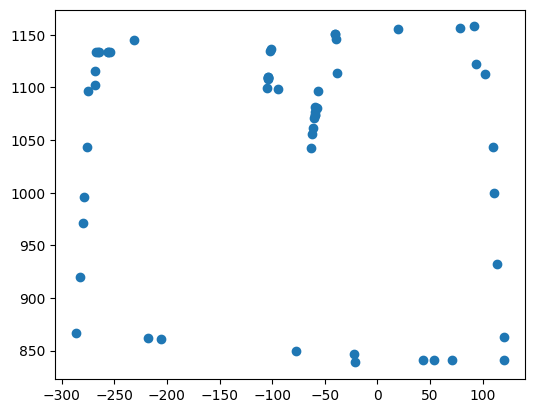

In [778]:
bdf.plot(aspect=1)

In [779]:
gdf = bdf.copy()

In [780]:
# 輪郭の点群をDataframeとして取得する
# 終点が追加されて+1行となる
# ポリゴンごとにIDを付与してくれているので、どのポリゴンの点なのか識別できる
ex = gdf.geometry.explode(index_parts=True)

In [781]:
# GeoSeries to pd.DataFrame
df = pd.DataFrame({
    "x":ex.x,
    "y":ex.y
}).reset_index(drop=False)

In [782]:
# 局所方向符号を定義する
# Cn_secがもとまる
cn_list = []
for c in range(df.shape[0] - 1):
    cc = c + 1
    if cc < df.shape[0] - 1:
        fir = df.loc[cc-1,:].values
        sec = df.loc[cc,:].values
        thr = df.loc[cc+1,:].values
    else:
        fir = df.loc[cc-1,:].values
        sec = df.loc[cc,:].values
        thr = df.loc[1,:].values

    v1 = sec - fir
    v2 = thr - sec

    if v2[1] < 0 :
        r = 180
    else:
        r = 0

    n1 = np.linalg.norm(v1, ord=2)
    n2 = np.linalg.norm(v2, ord=2)

    d = np.dot(v1, v2)

    cos = d / (n1 * n2)

    # Cn_secの角度
    theta = np.arccos(cos)
    theta = r + np.degrees(theta)
    print("theta", "Cn", cc, theta)

    # 局所方向符号:cn
    if (0 <= theta < 45):
        cn = 0
    elif (45 <= theta < 90):
        cn = 1
    elif (90 <= theta < 135):
        cn = 2
    elif (135 <= theta < 180):
        cn = 3
    elif (180 <= theta < 225):
        cn = 4
    elif (225 <= theta < 270):
        cn = 5
    elif (270 <= theta < 315):
        cn = 6
    elif (315 <= theta < 360):
        cn = 7

    print("局所方向符号", cn)
    cn_list.append(cn)

theta Cn 1 41.30988528813098
局所方向符号 0
theta Cn 2 29.851038825293767
局所方向符号 0
theta Cn 3 91.23643884137864
局所方向符号 2
theta Cn 4 21.65993628431892
局所方向符号 0
theta Cn 5 75.21198258518675
局所方向符号 1
theta Cn 6 8.66230618480368
局所方向符号 0
theta Cn 7 12.163009684215861
局所方向符号 0
theta Cn 8 23.547364753241506
局所方向符号 0
theta Cn 9 51.08723012887749
局所方向符号 1
theta Cn 10 90.61753876674429
局所方向符号 2
theta Cn 11 3.828733641273847
局所方向符号 0
theta Cn 12 90.63139563460513
局所方向符号 2
theta Cn 13 87.05919278604185
局所方向符号 1
theta Cn 14 80.26909982106636
局所方向符号 1
theta Cn 15 14.082081200404078
局所方向符号 0
theta Cn 16 24.331650154142345
局所方向符号 0
theta Cn 17 24.5684744949666
局所方向符号 0
theta Cn 18 19.793768207668524
局所方向符号 0
theta Cn 19 4.1131213487333955
局所方向符号 0
theta Cn 20 5.279430297806654
局所方向符号 0
theta Cn 21 4.53195514513441
局所方向符号 0
theta Cn 22 90.8884354922813
局所方向符号 2
theta Cn 23 3.9283145319603685
局所方向符号 0
theta Cn 24 3.4806131616014797
局所方向符号 0
theta Cn 25 89.12152864901911
局所方向符号 1
theta Cn 26 0.109529374314069

In [783]:
# 調整
df = df.loc[:df.shape[0] - 2,:]
cn_list.insert(0, cn_list[-1])
cn_list = cn_list[:-1]
df["Cn"] = cn_list

In [784]:
# 局所曲率符号: ca
# Cai = octmod(Cni - Cni-1 + 11) - 3
ca_list = []
for l in range(len(cn_list)):
    # llは1-8をとる　8をとるとout of range
    ll = l + 1
    if ll < len(cn_list):
        ca = ((cn_list[ll-1] - cn_list[ll] + 11 ) % 8 ) - 3
    else:
        ca = ((cn_list[ll-1] - cn_list[0] + 11 ) % 8 ) - 3
    ca_list.append(ca)
df["Ca"] = ca_list

In [785]:
def get_range_list(i, k):
    x = [tmp for tmp in range(df.shape[0])]
    xi = x.index(i)

    fir = xi - k
    sec = xi
    thr = xi + k

    if xi - k <= -1:
        under = df.shape[0] + xi - k
        tun = 0
    else:
        under = xi - k
        tun = 1

    if xi + k + 1 >= df.shape[0]:
        upper = xi + k + 1 - df.shape[0]
        tup = 0
    else:
        upper = xi + k + 1
        tup = 1
    if tun * tup == 1:
        r_l = x[under:upper]
    else:
        r_l = x[under:] + x[:upper]

    return r_l

In [786]:
# G-オペレーション
# M: Mは平滑化に用いる曲線上の連続した画素数
# Gi: 曲線の曲率半径が小さいほど、絶対値が大きくなる。
# 絶対値が大きい部分が曲線の角の部分であると考えられる
# +が左回り, -が右回り

M = 2
k = M - 1
s = 0
gi_list = []
for i in range(df.shape[0]):
    r_l = get_range_list(i, k)
    c = r_l.index(i)

    # CnとCaの値を抽出する
    tmp = df.loc[r_l, :]

    for tk in range(M-1) :
        ca_under = tmp.loc[r_l[c - tk], "Ca"]
        ca_upper = tmp.loc[r_l[c + tk], "Ca"]
        # print(ca_under, ca_upper)
        s = (M - k+1) * (ca_under + ca_upper) + s

    Gi = M * tmp.loc[i, "Ca"]  + s
    gi_list.append(Gi)
df["Gi"] = gi_list

In [787]:
"""
一致判定方法（案）

Q. 近似的な一致に対応できるか
Q.


1. 一方のポリゴンをずらしていいって、Giの二条和誤差が最小となるずらし回数を算出
2. 相互相関係数: 表をlevel_1で昇順・降順で並べた上で比較しないとずれる
3. 相互相関係数　→　類似部分を抽出　→　逆転

"""

'\n一致判定方法（案）\n\nQ. 近似的な一致に対応できるか\nQ.\n\n\n1. 一方のポリゴンをずらしていいって、Giの二条和誤差が最小となるずらし回数を算出\n2. 相互相関係数: 表をlevel_1で昇順・降順で並べた上で比較しないとずれる\n3. 相互相関係数\u3000→\u3000類似部分を抽出\u3000→\u3000逆転\n\n'

## 符号的：直線・角度的アプローチ

In [788]:
tdf = df.copy()

In [789]:
# 座標変換
min_x = tdf["x"].min()
min_y = tdf["y"].min()
tdf["x"] = tdf["x"] - min_x
tdf["y"] = tdf["y"] - min_y


In [792]:
# 特徴量の抽出 pd.DataFrame -> list -> pd.DataFrame(datamart)
# ポリゴンの個数
polygon_num = [i for i in tdf.level_0.unique()]
# 各ポリゴンのPOINT数
point_num = tdf.groupby("level_0").count()
point_num = point_num["level_1"].to_list()
# 角の抽出 # 主要な角の抽出条件は・・Cn>1かつCa>1かつGi>14 corner=0:直線, corner=1:角
conditions = (tdf["Cn"]>=1) & (tdf["Gi"] != 0)
tdf['corner'] = 1
tdf.loc[~conditions, 'corner'] = 0

# 角の抽出　ポリゴンごとに抽出する
# TODO
tdf_0 = tdf.loc[df["level_0"] == 0, :]
# cornerとlineをlevel_1をindexとして利用してlistで管理する
corner_df = tdf_0[tdf_0["corner"] != 0]
corner_df = corner_df.reset_index(drop=False)

# 直近のcorner同士のxy座標から距離を測定
# dfから測定に用いるレコードの組み合わせを抽出　indexを指定する
def leftShiftIndex(arr, n):
    result = arr[n:] + arr[:n]
    return result
list1 = corner_df["index"].to_list()
list2 = leftShiftIndex(list1,1)
line_index_list = []
for i,j in zip(list1, list2):
    line_index_list.append([i,j])

# 距離と傾きを算出 -> corner_dfに結合
diff_list = []
trend_list = []
for k in line_index_list:
    ia = k[0]
    ib = k[1]
    tmp = corner_df[(corner_df["index"] == ia) | (corner_df["index"] == ib)].reset_index(drop=True)
    # 距離を計算
    diff = ((tmp.loc[1,"x"] - tmp.loc[0,"x"])**2 + (tmp.loc[1,"y"] - tmp.loc[0,"y"])**2) ** 1/2
    diff_list.append(diff)
    # 傾きを計算
    trend = ((tmp.loc[0,"y"] - tmp.loc[1,"y"]) / (tmp.loc[0,"x"] - tmp.loc[1,"x"]))
    trend_list.append(trend)
corner_df["diff"] = diff_list
corner_df["trend"] = trend_list

# diffを丸める
from decimal import *

def make_round(d):
    # getcontext().rounding=ROUND_HALF_UP
    # getcontext().prec=1
    # d = float(Decimal(d))
    d = round(d, -3)
    return d

corner_df["diff"] = corner_df["diff"].apply(make_round)
# corner_df["trend"] = corner_df["trend"].apply(make_round)
# corner_df["diff"] = corner_df["diff"] * corner_df["trend"]

In [793]:
ans_0 = corner_df.copy()
# ans_1 = corner_df.copy()

In [794]:
ans_0 = ans_0[ans_0["diff"] != 0]
ans_1 = ans_1.sort_values("index",ascending=False)
ans_1 = ans_1[ans_1["diff"] != 0]

<Axes: >

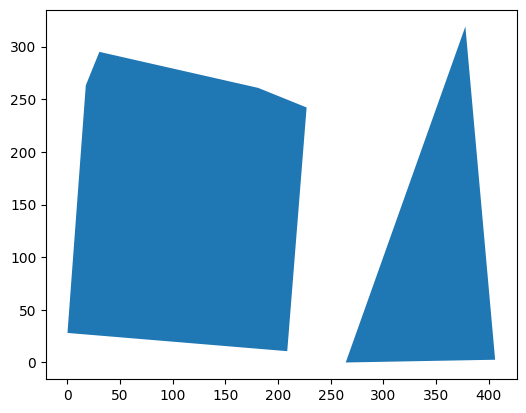

In [795]:
p0 = Polygon(gpd.points_from_xy(ans_0["x"], ans_0["y"]))
p1 = Polygon(gpd.points_from_xy(ans_1["x"], ans_1["y"]))
r_gdf = gpd.GeoDataFrame([p0, p1], geometry=0)
r_gdf.plot()

In [796]:
r_gdf["centroid"] = r_gdf.centroid
distance = r_gdf.loc[0,"centroid"].distance(r_gdf.loc[1,"centroid"])
distance

240.62874052731692

In [797]:
ans_0

,index,level_0,level_1,x,y,Cn,Ca,Gi,corner,diff,trend
0,0,0,0,30.290,295.059,6,-2,-12,1,12000.0,0.019031
4,10,0,10,181.118,260.839,2,2,-4,1,1000.0,-0.059361
7,14,0,14,227.149,242.229,1,1,-6,1,27000.0,12.582781
8,22,0,22,208.751,10.731,2,2,-4,1,22000.0,-0.083061
9,25,0,25,0.000,28.070,1,1,-6,1,27000.0,20.349836
11,31,0,31,17.411,263.267,1,1,-6,1,1000.0,24.925432


In [798]:
ans_1

,index,level_0,level_1,x,y,Cn,Ca,Gi,corner,diff,trend
2,51,1,14,264.316,0.000,1,1,26,1,57000.0,2.808426
1,47,1,10,406.239,2.598,2,2,28,1,10000.0,0.018306
0,40,1,3,377.964,319.172,2,2,28,1,51000.0,-11.196251


## 最小二乗法

In [799]:
a0_df = ans_0.copy()
a1_df = ans_1.copy()
a0_diff_list = a0_df["diff"]
a1_diff_list = a1_df["diff"]
a0_trend_list = a0_df["trend"]
a1_trend_list = a1_df["trend"]

In [800]:
def calculate_shifted_lse(arr1, arr2):
    min_error = np.inf
    best_shift = None

    # 配列1をずらしながら最小二乗誤差を計算
    for shift in range(len(arr1)):
        shifted_arr1 = np.roll(arr1, shift)
        error = np.sum((shifted_arr1[:len(arr2)] - arr2) ** 2)

        if error < min_error:
            min_error = error
            best_shift = shift

    return min_error, best_shift

# サンプルの配列を作成
# len(arr2) > len(arr1)
if len(a0_diff_list) >= len(a1_diff_list):
    arr1_diff = a0_diff_list
    arr2_diff = a1_diff_list
    arr1_trend = a0_trend_list
    arr2_trend = a1_trend_list
else:
    arr1_diff = a1_diff_list
    arr2_diff = a0_diff_list
    arr1_trend = a1_trend_list
    arr2_trend = a0_trend_list

# ずらしながら最小二乗誤差を計算
error_diff, shift_diff = calculate_shifted_lse(arr1_diff, arr2_diff)
error_trend, shift_trend = calculate_shifted_lse(arr1_trend, arr2_trend)
print(f"最小二乗誤差: {error_diff}")
print(f"最適なずらし: {shift_diff}") # OK
print(f"最小二乗誤差: {error_trend}")
print(f"最適なずらし: {shift_trend}") # OK
ss_list = [shift_diff, shift_trend]
shift = shift_diff

最小二乗誤差: 1620000000.0
最適なずらし: 4
最小二乗誤差: 289.5932395454801
最適なずらし: 5


In [801]:
ss_list

[4, 5]

In [802]:
a0_df

,index,level_0,level_1,x,y,Cn,Ca,Gi,corner,diff,trend
0,0,0,0,30.290,295.059,6,-2,-12,1,12000.0,0.019031
4,10,0,10,181.118,260.839,2,2,-4,1,1000.0,-0.059361
7,14,0,14,227.149,242.229,1,1,-6,1,27000.0,12.582781
8,22,0,22,208.751,10.731,2,2,-4,1,22000.0,-0.083061
9,25,0,25,0.000,28.070,1,1,-6,1,27000.0,20.349836
11,31,0,31,17.411,263.267,1,1,-6,1,1000.0,24.925432


In [803]:
a1_df

,index,level_0,level_1,x,y,Cn,Ca,Gi,corner,diff,trend
2,51,1,14,264.316,0.000,1,1,26,1,57000.0,2.808426
1,47,1,10,406.239,2.598,2,2,28,1,10000.0,0.018306
0,40,1,3,377.964,319.172,2,2,28,1,51000.0,-11.196251


In [804]:
l0 = a0_df[["level_0", "level_1", "x", "y", "Gi"]].reset_index(drop=True)
l1 = a1_df[["level_0", "level_1", "x", "y", "Gi"]].sort_values('level_1', ascending=False).reset_index(
    drop=True).reset_index(drop=False)

# アンサンブルのために複数の候補を試す
dd_list = []
diff_x_list = []
diff_y_list = []
for shift in ss_list:
    shift_list = [shift-1, shift, shift+1, shift+2, shift+3, shift+5]
    for diff_index in shift_list:
        # シフトを標準から±いくつかを試す。
        if diff_index >= l1.shape[0]:
            diff_index = diff_index - l1.shape[0]

        l0_x = l0.loc[1, "x"]
        l0_y = l0.loc[1, "y"]
        l1_x = l1.loc[diff_index, "x"]
        l1_y = l1.loc[diff_index, "y"]
        print(l0_x, l0_y, l1_x, l1_y)
        diff_x = l0_x - l1_x
        diff_y = l0_y - l1_y
        diff_x_list.append(diff_x)
        diff_y_list.append(diff_y)
        # 移動距離（判定に使う）
        dd = ((diff_x)**2 + (diff_y)**2) ** 1/2
        dd_list.append(dd)
min_index = dd_list.index(min(dd_list))
diff_x = diff_x_list[min_index]
diff_y = diff_y_list[min_index]

# dd > distanceの場合、処理をやめる
if dd_list[min_index] > distance:
    print(1)

# l1にdiffを加算する
a1_df["x"] = a1_df["x"] + diff_x
a1_df["y"] = a1_df["y"] + diff_y

ll0 = a0_df[["level_0", "x","y"]]
ll1 = a1_df[["level_0", "x", "y"]]

p1 = Polygon(gpd.points_from_xy(ll0["x"], ll0["y"]))
p2 = Polygon(gpd.points_from_xy(ll1["x"], ll1["y"]))
r_gdf = gpd.GeoDataFrame([p1,p2], geometry=0)
r_gdf = r_gdf.reset_index(drop=False)

181.118 260.83899999999994 264.31600000000003 0.0
181.118 260.83899999999994 406.23900000000003 2.5979999999999563
181.118 260.83899999999994 377.964 319.172


KeyError: 3

In [762]:
min_index

1

In [763]:
dd_list[min_index]

1972.8082899999984

In [764]:
r_gdf

,index,0
0,0,"POLYGON ((326.228 406.555, 350.628 294.873, 86..."
1,1,"POLYGON ((358.601 66.108, 350.628 294.873, 78...."


<Axes: >

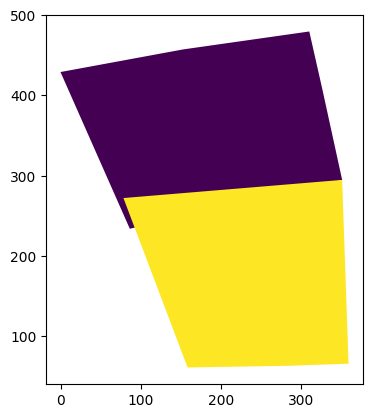

In [765]:
r_gdf.plot("index")

In [714]:
dd_list

[15167.242119999997,
 0.0,
 5948.324946499998,
 16308.116858500005,
 25920.3438485,
 34836.741605,
 5948.324946499998,
 16308.116858500005,
 25920.3438485,
 25269.816068000004,
 34836.741605,
 49038.7270105]

In [674]:
shift

8

## 相互相関をとってみる

In [ ]:
# data1

In [ ]:
# data2

In [ ]:
# # 二つの時系列データの相互相関係数を算出
# data1 = ans_0.loc[:,"diff"]
# data2 = ans_1.loc[:,"diff"]
# # クロス相関関数の計算
# cross_corr = np.correlate(data1, data2, mode='full')
# # クロス相関関数のプロット
# import plotly.express as px
# fig = px.line(cross_corr)
# fig.show()

In [ ]:
# # cross_corr = cross_corr[:ans_0.shape[0]]
# indices = np.argwhere(cross_corr == cross_corr.max())
# # diff_index = indices[0][0] -2  # ラグdiff_indexで最も相互相関係数が上昇する→diff_indexシフトすると輪郭の一致する部分が重なる。
# diff_index =  0
# print(diff_index)

In [ ]:
# """
# 相互相関係数が最大値の19 - 2だけ移動すると一致する。
# """
# l0 = ans_0[["level_0", "level_1", "x", "y", "diff"]]
# l1 = ans_1[["level_0", "level_1", "x", "y", "diff"]].sort_values('level_1', ascending=False).reset_index(
#     drop=True).reset_index(drop=False)
# diff_index
# l0_x = l0.loc[0, "x"]
# l0_y = l0.loc[0, "y"]
# l1_x = l1.loc[diff_index, "x"]
# l1_y = l1.loc[diff_index, "y"]
#
# print(l0_x, l0_y, l1_x, l1_y)
# diff_x = l0_x - l1_x
# diff_y = l0_y - l1_y
#
# # l1にdiffを加算する
# ans_1["x"] = ans_1["x"] + diff_x
# ans_1["y"] = ans_1["y"] + diff_y
#
# ll0 = ans_0[["level_0", "x","y"]]
# ll1 = ans_1[["level_0", "x", "y"]]
#
# p1 = Polygon(gpd.points_from_xy(ll0["x"], ll0["y"]))
# p2 = Polygon(gpd.points_from_xy(ll1["x"], ll1["y"]))
# r_gdf = gpd.GeoDataFrame([p1,p2], geometry=0)
# r_gdf